In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Utilites

In [2]:
exp_weights=[]
exp_vorfaktoren=[]
# u1 - risk neutral
exp_weights.append([1.5,-1.5])
exp_vorfaktoren.append([0.3,-0.3])

#u2 - risk seeker
exp_weights.append([1,-0.5])
exp_vorfaktoren.append([1.5,-0.1])

#u3 - risk averse
exp_weights.append([0.6,-0.6])
exp_vorfaktoren.append([0.05,-2.5])

In [3]:
exp_weights

[[1.5, -1.5], [1, -0.5], [0.6, -0.6]]

In [4]:
def utility(weights,vors,x):
    y=np.zeros(len(x))
    for i in range(len(weights)):
        y+=weights[i]*np.exp(x*vors[i])
    return y

In [5]:
xmax=1.5
xmin=-xmax
x=np.linspace(xmin,xmax,101)

In [6]:
y=[]
labels=[]
for i in range(len(exp_weights)):
    y.append(utility(exp_weights[i],exp_vorfaktoren[i],x))
    labels.append('U'+str(i+1))

In [7]:
labels

['U1', 'U2', 'U3']

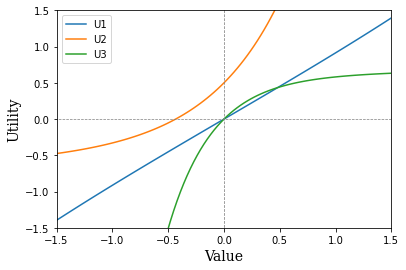

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ymin=np.inf
ymax=-np.inf
for i in range(len(exp_weights)):
    ax.plot(x,y[i],label=labels[i])
    if np.min(y[i])<ymin:
        ymin=np.min(y[i])
    if np.max(y[i])>ymax:
        ymax=np.max(y[i])
ax.vlines(x=0, ymin=ymin-1, ymax=ymax+1 ,colors='gray', linestyles='dashed',linewidth=0.75)
ax.hlines(y=0, xmin=xmin-1, xmax=xmax+1 ,colors='gray', linestyles='dashed',linewidth=0.7)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
ax.set_xlabel('Value',fontsize=14,fontfamily='serif')
ax.set_ylabel('Utility',fontsize=14,fontfamily='serif')
ax.legend()
####################################################



fig.savefig('./Figs\\utilities.png')

Sigmoid


In [15]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [13]:
sig_weights=np.array([ 0.38128631,  0.40403653, -0.42755153, -0.18214049,  0.32200875])

In [14]:
sig_vors=np.array([ 0.29061874,  0.28760981, -0.00912803,  0.65379036,  0.29824003])

In [16]:
x=np.linspace(-3,3,101)

In [17]:
y=sigmoid(x)

In [19]:
y_hat=utility(sig_weights,sig_vors,x)

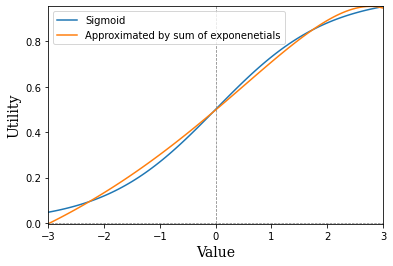

In [36]:
xmax=3
xmin=-xmax
ymax=np.max([np.max(y),np.max(y_hat)])
ymin=np.min([np.min(y),np.min(y_hat)])

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(x,y, label='Sigmoid')
ax.plot(x,y_hat,label='Approximated by sum of exponenetials')
ax.vlines(x=0, ymin=ymin-1, ymax=ymax+1 ,colors='gray', linestyles='dashed',linewidth=0.75)
ax.hlines(y=0, xmin=xmin-1, xmax=xmax+1 ,colors='gray', linestyles='dashed',linewidth=0.7)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
ax.set_xlabel('Value',fontsize=14,fontfamily='serif')
ax.set_ylabel('Utility',fontsize=14,fontfamily='serif')
ax.legend()

fig.savefig('./Figs\\sigmoid_fit.png')


## simuls

In [37]:
import numpy as np
from datetime import datetime
import os
import itertools as it
from env import *
import pandas as pd
import random
from Beurele_agent import *
from MO_agent import *

In [38]:
e=tiger_POMDP_env(read_config=True,config_address='./tiger.json',parameters=None)
num_to_act=dict(zip(list(e.actions.values()),list(e.actions.keys())))
e.discount_factor=1

{'state_change_r2l': 0.1, 'state_change_l2r': 0.1, 'false_observation_get_l_while_r': 0.2, 'false_observation_get_r_while_l': 0.2, 'reward_listen': -0.1, 'reward_low_incorrect': -0.2, 'reward_high_incorrect': -0.4, 'reward_low_correct': 0.2, 'reward_high_correct': 0.4, 'discount_factor': 1, 'initial_wealth': 0}


In [65]:
planning_depth=2
utility_type=3
partitioning_chunk_number=1000

exp_weights=[]
exp_vorfaktoren=[]
# u1 - risk neutral
exp_weights.append([1.5,-1.5])
exp_vorfaktoren.append([0.3,-0.3])

#u2 - risk seeker
exp_weights.append([1,-0.5])
exp_vorfaktoren.append([1.5,-0.1])

#u3 - risk averse
exp_weights.append([0.6,-0.6])
exp_vorfaktoren.append([0.05,-2.5])

#u4 - sigmoid
exp_weights.append([ 0.38128631,  0.40403653, -0.42755153, -0.18214049,  0.32200875])
exp_vorfaktoren.append([ 0.29061874,  0.28760981, -0.00912803,  0.65379036,  0.29824003])

initial_theta=[0.5,0.5]
initial_observation=0
modes=['discrete_optimized','naive','cheating']

In [66]:
###############    Environment

e.reset()
initial_observation=e.current_state
observation=initial_observation
state=e.current_state

##############     Agent 

ag=Multi_Variate_agent(environment=e, planning_depth=planning_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
ag.reset()
mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=ag.pre_planning(exp_vorfaktoren=exp_vorfaktoren[utility_type],exp_weights=exp_weights[utility_type], initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
mo_value_func,mo_action_func,mo_q_func,vf2=ag.value_iteration()

In [67]:
##############       Simulation
for t in range(planning_depth):
    
    print('t=',t)
    print('------')
    print('state:',state,e.states[state])
    print('last_observation:',observation)
    print('-------------------------------')
    print('')
    print('current internal state:',ag.current_internal_state)
    print('')
    
    # agent select the action
    action,value_of_action=ag.do_action()
    
    #environment feedback
    t1,t2,state,reward,observation=e.step(num_to_act[action])
    
    # agent update
    new_x=ag.update_agent(new_observation=observation) 
    
    print('             action:',num_to_act[action])  
    print ('             **' )
    print('reward:',reward,'new observation:',observation)
    print('')
    print('new internal state:', ag.current_internal_state)
    print('')
    print('============================')

t= 0
------
state: 0 tiger_right
last_observation: 0
-------------------------------

current internal state: ((0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0), (0, 0, 0, 0, 0), 0)

             action: listen
             **
reward: -0.1 new observation: 0

new internal state: ((0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0), (-0.1, -0.1, -0.1, -0.1, -0.1), 1)

t= 1
------
state: 1 tiger_left
last_observation: 0
-------------------------------

current internal state: ((0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0), (-0.1, -0.1, -0.1, -0.1, -0.1), 1)

             action: open_left_high
             **
reward: -0.4 new observation: 0

new internal state: ((0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0), (0.1541921016, 0.1540521492, 0.1395319622, 0.1700418925, 0.154545939), 2)



### Simuls count actions

In [1]:
import numpy as np
from datetime import datetime
import os
import itertools as it
from env import *
import pandas as pd
import random
from Beurele_agent import *
from MO_agent import *

In [2]:
e=tiger_POMDP_env(read_config=True,config_address='./tiger.json',parameters=None)
num_to_act=dict(zip(list(e.actions.values()),list(e.actions.keys())))
e.discount_factor=1

{'state_change_r2l': 0.1, 'state_change_l2r': 0.1, 'false_observation_get_l_while_r': 0.2, 'false_observation_get_r_while_l': 0.2, 'reward_listen': -0.1, 'reward_low_incorrect': -0.2, 'reward_high_incorrect': -0.4, 'reward_low_correct': 0.2, 'reward_high_correct': 0.4, 'discount_factor': 1, 'initial_wealth': 0}


In [3]:

exp_weights=[]
exp_vorfaktoren=[]
# u1 - risk neutral
exp_weights.append([1.5,-1.5])
exp_vorfaktoren.append([0.3,-0.3])

#u2 - risk seeker
exp_weights.append([1,-0.5])
exp_vorfaktoren.append([1.5,-0.1])

#u3 - risk averse
exp_weights.append([0.6,-0.6])
exp_vorfaktoren.append([0.05,-2.5])

#u4 - sigmoid
exp_weights.append([ 0.38128631,  0.40403653, -0.42755153, -0.18214049,  0.32200875])
exp_vorfaktoren.append([ 0.29061874,  0.28760981, -0.00912803,  0.65379036,  0.29824003])

initial_theta=[0.5,0.5]
initial_observation=0
modes=['discrete_optimized','naive','cheating']

In [ ]:
#planning_depth=2
#utility_type=3
partitioning_chunk_number=1000


In [ ]:
###############    Environment

e.reset()
initial_observation=e.current_state
observation=initial_observation
state=e.current_state

##############     Agent 

ag=Multi_Variate_agent(environment=e, planning_depth=planning_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
ag.reset()
mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=ag.pre_planning(exp_vorfaktoren=exp_vorfaktoren[utility_type],exp_weights=exp_weights[utility_type], initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
mo_value_func,mo_action_func,mo_q_func,vf2=ag.value_iteration()

In [18]:
partitioning_chunk_number=1000
data=pd.DataFrame(columns=['planning_depth','utility_type','trial','inner_trial','step','action'])
for planning_depth in [3,4,5]:
    for utility_type in range(len(exp_weights)):
        e.reset()
        initial_observation=e.current_state
        observation=initial_observation
        state=e.current_state

        ag=Multi_Variate_agent(environment=e, planning_depth=planning_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
        ag.reset()
        mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=ag.pre_planning(exp_vorfaktoren=exp_vorfaktoren[utility_type],exp_weights=exp_weights[utility_type], initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
        mo_value_func,mo_action_func,mo_q_func,vf2=ag.value_iteration()

        for repeate in range(30):
            for iteration in range(100):

                e.reset()
                initial_observation=e.current_state
                observation=initial_observation
                state=e.current_state
                ag.reset()

                for t in range(planning_depth):

                    # agent select the action
                    action,value_of_action=ag.do_action()

                    #environment feedback
                    t1,t2,state,reward,observation=e.step(num_to_act[action])

                    # agent update
                    new_x=ag.update_agent(new_observation=observation) 

                    tmp={}
                    tmp['planning_depth']=planning_depth
                    tmp['utility_type']=utility_type
                    tmp['trial']=repeate
                    tmp['inner_trial']=iteration
                    tmp['step']=t
                    tmp['action']=action
                    data=data.append(tmp.copy(),ignore_index=True)

            
pd.to_pickle(data,'./Figs\\simul1.pkl')       

In [19]:
a=pd.read_pickle('./Figs\\simul1.pkl')

In [47]:
summary=pd.DataFrame(columns=['depth','utility','step','listen','low','high'])
for p in [3,4,5]:
    each_p=a.loc[a.planning_depth==p]
    for u in [0,1,2,3]:
        each_u=each_p.loc[each_p.utility_type==u,['step','action']]
        for step in range(p):
            each_s=np.array(each_u.loc[each_u.step==step,'action'].to_list())
            total=len(each_s)
            listen=len(np.where(each_s==0)[0])/total
            high=len(np.where(each_s>2)[0])/total
            low=1-(listen+high)
            tmp={}
            tmp['depth']=p
            tmp['utility']=u
            tmp['step']=step
            tmp['listen']=listen
            tmp['low']=low
            tmp['high']=high
            
            summary=summary.append(tmp.copy(),ignore_index=True)

In [49]:
summary

,depth,utility,step,listen,low,high
0,3.0,0.0,0.0,1.0,0.0,0.0
1,3.0,0.0,1.0,0.0,0.0,1.0
2,3.0,0.0,2.0,0.0,0.0,1.0
3,3.0,1.0,0.0,0.0,0.0,1.0
4,3.0,1.0,1.0,0.0,0.0,1.0
5,3.0,1.0,2.0,0.0,0.0,1.0
6,3.0,2.0,0.0,1.0,0.0,0.0
7,3.0,2.0,1.0,0.0,1.0,0.0
8,3.0,2.0,2.0,0.0,1.0,0.0
9,3.0,3.0,0.0,1.0,0.0,0.0


The results are exterem and in my opinion not valuable to present in the paper.

## Performance

## time

In [40]:
mo_times=[]
b_times=[]
mo_states=[]
b_states=[]

for i in range(8):
    planning_depth=i+1
    utility_type=3
    partitioning_chunk_number=1000
    initial_Mu=[0.5,0.5]
    
    ##### MO
    e.reset()
    initial_observation=e.current_state
    observation=initial_observation
    state=e.current_state

    ##############     Agent 
    t=datetime.now()
    agm=Multi_Variate_agent(environment=e, planning_depth=planning_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
    agm.reset()
    mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=agm.pre_planning(exp_vorfaktoren=exp_vorfaktoren[utility_type],exp_weights=exp_weights[utility_type], initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
    mo_value_func,mo_action_func,mo_q_func,vf2=agm.value_iteration()
    t=datetime.now()-t
    total=0
    for i in range(planning_depth+1):
        total+=len(mo_value_func[i])
    mo_times.append(t)
    mo_states.append(total)
    print(t)
    ############# Bauerle
    e.reset()
    initial_observation=e.current_state
    observation=initial_observation
    state=e.current_state
    ##############       Agent

    t=datetime.now()
    # Create the agent
    agb=Bauerle_Rieder_agent(environment=e, num_of_Mu_chunks=2,max_iterations=planning_depth)

    # Run its value iteration
    b_S,b_reachables,b_map,b_q_func,b_value_function,b_action_func=agb.continious_optimized_planning(initial_mu_state=initial_Mu,initial_observation=initial_observation,initial_wealth=0,exp_weights=exp_weights[utility_type],exp_vorfaktoren=exp_vorfaktoren[utility_type])

    t=datetime.now()-t
    total=0
    for i in range(planning_depth+1):
        total+=len(b_value_function[i])
    b_times.append(t)
    b_states.append(total)
    

0:00:00.021942
0:00:00.044849
0:00:00.212459
0:00:01.409189
0:00:13.385740
0:01:36.972514
0:12:33.096396
1:34:52.931517


<B> Sigmoid

In [41]:
mo_times

[datetime.timedelta(microseconds=21942),
 datetime.timedelta(microseconds=44849),
 datetime.timedelta(microseconds=212459),
 datetime.timedelta(seconds=1, microseconds=409189),
 datetime.timedelta(seconds=13, microseconds=385740),
 datetime.timedelta(seconds=96, microseconds=972514),
 datetime.timedelta(seconds=753, microseconds=96396),
 datetime.timedelta(seconds=5692, microseconds=931517)]

In [43]:
b_times

[datetime.timedelta(microseconds=7013),
 datetime.timedelta(microseconds=28927),
 datetime.timedelta(microseconds=134650),
 datetime.timedelta(seconds=1, microseconds=492019),
 datetime.timedelta(seconds=16, microseconds=276485),
 datetime.timedelta(seconds=129, microseconds=354197),
 datetime.timedelta(seconds=1107, microseconds=832088),
 datetime.timedelta(seconds=9253, microseconds=30900)]

In [44]:
mo_states

[7, 29, 99, 317, 959, 2817, 8035, 22459]

In [45]:
b_states

[7, 29, 99, 317, 959, 2817, 8035, 22459]

In [16]:
planning_depth=7
utility_type=3
partitioning_chunk_number=1000
initial_Mu=[0.5,0.5]

In [17]:
e.reset()
initial_observation=e.current_state
observation=initial_observation
state=e.current_state

##############     Agent 
t=datetime.now()
agm=Multi_Variate_agent(environment=e, planning_depth=planning_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
agm.reset()
mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=agm.pre_planning(exp_vorfaktoren=exp_vorfaktoren[utility_type],exp_weights=exp_weights[utility_type], initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
mo_value_func,mo_action_func,mo_q_func,vf2=agm.value_iteration()
print(datetime.now()-t)
total=0
for i in range(planning_depth+1):
    total+=len(mo_value_func[i])
    

0:13:05.916040


In [18]:
len(mo_value_func[2])

22

In [19]:
e.reset()
initial_observation=e.current_state
observation=initial_observation
state=e.current_state
##############       Agent

t=datetime.now()
# Create the agent
agb=Bauerle_Rieder_agent(environment=e, num_of_Mu_chunks=2,max_iterations=planning_depth)

# Run its value iteration
b_S,b_reachables,b_map,b_q_func,b_value_function,b_action_func=agb.continious_optimized_planning(initial_mu_state=initial_Mu,initial_observation=initial_observation,initial_wealth=0,exp_weights=exp_weights[utility_type],exp_vorfaktoren=exp_vorfaktoren[utility_type])

print(datetime.now()-t)
total=0
for i in range(planning_depth+1):
    total+=len(b_value_function[i])

0:18:36.391048


In [20]:
total

8035

In [1]:
import numpy as np
from datetime import datetime
import os
import itertools as it
from env import *
import pandas as pd
import random
from Beurele_agent import *
from MO_agent import *

In [2]:
e=tiger_POMDP_env(read_config=True,config_address='./tiger.json',parameters=None)
num_to_act=dict(zip(list(e.actions.values()),list(e.actions.keys())))
e.discount_factor=1
e.reset()

{'state_change_r2l': 0.1, 'state_change_l2r': 0.1, 'false_observation_get_l_while_r': 0.2, 'false_observation_get_r_while_l': 0.2, 'reward_listen': -0.1, 'reward_low_incorrect': -0.2, 'reward_high_incorrect': -0.4, 'reward_low_correct': 0.2, 'reward_high_correct': 0.4, 'discount_factor': 1, 'initial_wealth': 0}


In [24]:
maximum_depth=3
num_of_Mu_chunks=5

setting='d'+str(maximum_depth)+'c'+str(num_of_Mu_chunks)

t=datetime.now()

# Create the agent
agb=Bauerle_Rieder_agent(environment=e, num_of_Mu_chunks=num_of_Mu_chunks,max_iterations=maximum_depth)

# Pre-planning
agb.pre_planning_paration(make_and_save_Mu=True)

# Value-iteration
#agb.value_iteration(utility_function='risk-neutral',save_results=False,load_results=False,depth_and_chunks=setting)


total=0
files=os.listdir('./Universal_Mu')
for file in files:
    f=np.load(os.path.join('./Universal_Mu',file),allow_pickle=True)
    total+=len(f)
total*=2
print('states:',total)
#print('possible wealths:',agb.S)
 
    
    
t=datetime.now()-t
print(t)

states: 3713636
0:10:02.962694


3: 00:21 
4: 10:02   3713636


In [25]:
maximum_depth=3
partitioning_chunk_number=100
exp_vorfaktoren=[0.1,0.2,0.3]
exp_weights=[0.1,0.2,0.3]
initial_theta=[0.5,0.5]
initial_observation=0

ag=Multi_Variate_agent(environment=e, planning_depth=3, partitioning_chunk_number=partitioning_chunk_number,agent_mode='cheating')
ag.reset()
mo_x_map,mo_M,mo_F,mo_G,mo_reachables,mo_value_function_zero,mo_all_thetas=ag.pre_planning(exp_vorfaktoren=exp_vorfaktoren,exp_weights=exp_weights, initial_theta=initial_theta,initial_observation=initial_observation,initial_wealth=0)
#mo_value_func,mo_action_func,mo_q_func,vf2=ag.value_iteration()

In [32]:
mo_reachables[1][0]

((0.8, 0.2, 0.8, 0.2, 0.8, 0.2, 0.0), (-0.1, -0.1, -0.1), 1)

In [ ]:
maximum_depth=3
partitioning_chunk_number=100

setting='d'+str(maximum_depth)+'c'+str(num_of_Mu_chunks)

t=datetime.now()

agm=Multi_Variate_agent(environment=e, planning_depth=maximum_depth, partitioning_chunk_number=partitioning_chunk_number,agent_mode='naive')
agm.reset()
x_map,M,F,G,X,value_function,all_theta=agm.pre_planning(exp_vorfaktoren, initial_theta=initial_theta,initial_observation=initial_observation)

# Value-iteration
#agm.value_iteration()


total=0
files=os.listdir('./Universal_Mu')
for file in files:
    f=np.load(os.path.join('./Universal_Mu',file),allow_pickle=True)
    total+=len(f)
total*=2
print('states:',total)
#print('possible wealths:',agb.S)
 
    
    
t=datetime.now()-t
print(t)